In [50]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import sympy

In [51]:
# defines the letters used later as sympy symbols
x,A,ω,φ,y0,μ,Γ,M,A_DRAG = sympy.symbols("x,A,ω,φ,y0,μ,Γ,M,A_DRAG")

# window function for a Blackman pulse
# func is a sympy symbolic expression
def window(func):
    return sympy.Piecewise(
        (0, x>μ+M/2),
        (0, x<μ-M/2),
        (func, True)
    )

# shape functions

sinusoid_sym = A*sympy.cos(ω*x-φ)+y0

# CHECK THE SHIFTS FOR THE DRAG ADDITIONS
# for Gaussian it's pi/2, but for Blackman M/2 seems to work instead?

gaussian_sym = A*sympy.exp((-4*np.log(2)*((x-μ)**2))/(Γ**2))
gaussian_sym += A_DRAG * sympy.diff(gaussian_sym, x).subs(x, x-sympy.pi/2)

blackman_sym = A*(1-(0.42 - 0.5 * sympy.cos(2*sympy.pi*(x-μ)/M) + 0.08 * sympy.cos(4*sympy.pi*(x-μ)/M)))
blackman_sym = window(blackman_sym + A_DRAG * sympy.diff(blackman_sym, x).subs(x, x-M/2))

# converts the symbolic expressions to actual functions

sinusoid_func = sympy.lambdify([x,A,ω,φ,y0], sinusoid_sym, "numpy")
gaussian_func = sympy.lambdify([x,A,μ,Γ,A_DRAG], gaussian_sym, "numpy")
blackman_func = sympy.lambdify([x,A,μ,M,A_DRAG], blackman_sym, "numpy")

# sinusoid
def sinusoid(x_val,A_val,ω_val,φ_val,y0_val):
    return sinusoid_func(x_val,A_val,ω_val,φ_val,y0_val)

# gaussian
# not normalised
# Γ is FWHM
def gaussian(x_val,A_val,μ_val,Γ_val,A_DRAG_val=0):
    # the defaualt A_DRAG_val=0 is only for the optimum finding function, and must be specified for the actual pulse.
    return gaussian_func(x_val,A_val,μ_val,Γ_val,A_DRAG_val)

# blackman
# as defined on the numpy page
# Γ_val is the FWHM, while M is the Blackman parameter
def blackman(x_val,A_val,μ_val,Γ_val,A_DRAG_val): 
    M_val = Γ_val / 0.810957 # conversion from FWHM to Blackman parameter
    return blackman_func(x_val,A_val,μ_val,M_val,A_DRAG_val)

In [52]:
# function to calculate transition frequency
def calculate_ω(transmon, n1, n2):
    return (transmon.Ω - 0.5*transmon.α) * np.abs(n2 - n1) + 0.5 * transmon.α * (n2**2 - n1**2)

# function to calculate the level occupancy operator
def level_operator(n_levels, n):
    return basis(n_levels, n) * basis(n_levels, n).dag()

In [53]:
class transmon:

    def __init__(self, n_levels:int, initial_level:int, Ω:float=5000, α:float=-350, t_decay:float=np.inf, t_dephase:float=np.inf):
        
        self.n_levels = n_levels
        self.initial_level = initial_level
        self.Ω = Ω
        self.α = α
        self.t_decay = t_decay
        self.t_dephase = t_dephase

        self.ψ0 = basis(n_levels, initial_level)

        self.a = destroy(n_levels)
        self.n = self.a.dag() * self.a

In [54]:
class driver:

    def __init__(self, transmon, pulse_func, RWA):
        # pulse_func is "gaussian", "blackman", or "sinusoid"
        self.transmon = transmon
        self.pulse_func = pulse_func

        # not having RWA seems to make a significant difference: what's going wrong?
        if RWA:
            H0 = transmon.n*transmon.Ω + 0.5 * transmon.α * transmon.n * (transmon.n-1)
        else:
            H0 = (transmon.Ω-transmon.α)*(transmon.n+0.5) + ((transmon.Ω-transmon.α)**2)/(8*transmon.α) + (transmon.α*(transmon.a+transmon.a.dag())**4)/12 # worth going to higher order terms?

        H1 = transmon.a + transmon.a.dag()
        H1_coeffs = self.__make_H1_coeffs__()

        self.H = [H0, [H1, H1_coeffs]]

    def __make_H1_coeffs__(self):

        if self.pulse_func == "gaussian":
            def H1_coeffs(t, args):
                A,μ,Γ,ω,A_DRAG = args["A"],args["μ"],args["Γ"],args["ω"],args["A_DRAG"]
                return sinusoid(t,1,ω,ω*μ,0) * gaussian(t,A,μ,Γ,A_DRAG)

        elif self.pulse_func == "blackman":
            def H1_coeffs(t, args):
                A,μ,Γ,ω,A_DRAG = args["A"],args["μ"],args["Γ"],args["ω"],args["A_DRAG"]
                return sinusoid(t,1,ω,ω*μ,0) * blackman(t,A,μ,Γ,A_DRAG)
            
        elif self.pulse_func == "sinusoid":
            def H1_coeffs(t, args):
                A,ω,φ,y0 = args["A"],args["ω"],args["φ"],args["y0"]
                return sinusoid(t,A,ω,φ,y0)                

        else:
            raise ValueError("pulse_func must be gaussian, blackman, or sinusoid.")
                
        return H1_coeffs

    def visualise(self, t, args):
        plt.plot(t, self.H[1][1](t, args))
        plt.xlabel("Time [what units?]")
        plt.ylabel("Amplitude")
        plt.show()

In [55]:
def propagate(transmon, driver, t, args, plot):

    c_ops = [np.sqrt(1/transmon.t_decay) * transmon.a, np.sqrt(1/transmon.t_dephase) * transmon.n]
    e_ops = [level_operator(transmon.n_levels, i) for i in range(transmon.n_levels)]

    ψt = mesolve(driver.H, transmon.ψ0, t, c_ops, e_ops, args)

    if plot: 
        [plt.plot(t, i) for i in ψt.expect]
        plt.legend(["n="+str(i) for i in range(0, len(ψt.expect))])
        plt.xlabel("Time [what units?]")
        plt.ylabel("Probability")
        plt.title(", ".join([i + ": " + str(round(args[i],5)) for i in args])) # slicing to get rid of {} in output
        plt.show()

        _, ax = plt.subplots()
        dat = ax.bar([i for i in range(len(ψt.expect))], [round(i[-1], 5) for i in ψt.expect])
        ax.bar_label(dat)
        plt.xticks([i for i in range(len(ψt.expect))], ["n="+str(i) for i in range(len(ψt.expect))])
        plt.title("Final level probabilities")
        plt.xlabel("Energy level")
        plt.ylabel("Probability")
        plt.show()

    return ψt.expect

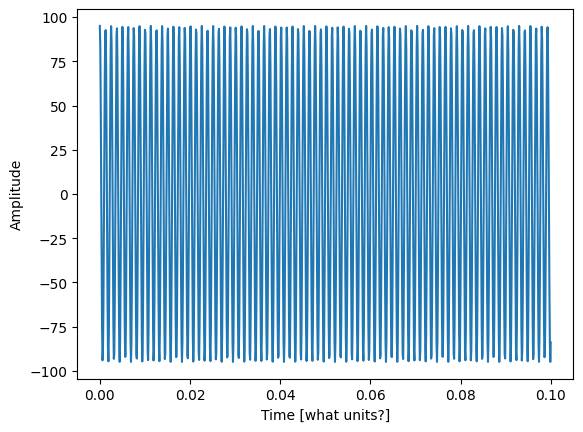

In [56]:
tr = transmon(3, 0, 5000,-350,np.inf, np.inf)
d = driver(tr, "sinusoid", True)

t = np.linspace(0, 0.1, 1000)

ω = calculate_ω(tr, 0, 1)

# for gaussian/blackman
# args = {"A":200,"μ":0.05,"Γ":0.01,"ω":ω,"A_DRAG":0}

# for sinusoid pulses
args = {"A":95,"ω":ω,"φ":0,"y0":0}

d.visualise(t, args)
expected = propagate(tr, d, t, args, False)

In [1]:
def spectroscopy(tr, d, args, frequencies, N):

    mean_expecteds = []

    for i in frequencies:
        args["ω"] = i
        expected = propagate(tr, d, t, args, False)
        mean_expecteds.append(list(np.mean(expected, 1)))

    mean_expecteds = [[i[j] for i in mean_expecteds] for j in range(3)]

    ω01 = calculate_ω(tr, 0, 1)
    ω02 = calculate_ω(tr, 0, 2)
    ω12 = calculate_ω(tr, 1, 2)

    [plt.plot(frequencies, i) for i in mean_expecteds]
    plt.axhline(y=0.5)
    plt.axvline(x=ω01, c='r')
    # plt.axvline(x=ω02)
    plt.axvline(x=ω12, c='g')
    plt.axvline(x=ω02/2, c='b')
    plt.show()

In [2]:
frequencies = np.linspace(4500, 5400, 500)
spectroscopy(tr, d, args, frequencies)


KeyboardInterrupt

